In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, bernoulli
from bitstring import BitArray
from math import sqrt
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("Airpollutiondata.csv")
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.set_index(['date'], drop=True)

In [3]:
#Converts dataframe to array
data = df.to_numpy()

#Split into training and test data
data_length = len(data)
train_split = 0.9
train_length = int(train_split * data_length)
test_length = data_length - train_length

x_train = data[0:train_length, :]
x_test = data[train_length:, :]

y_train = data[0:train_length, -1]
y_test = data[train_length:, -1]

In [4]:
x_scaler = MinMaxScaler((0,1))
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler((0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

print(x_train_scaled.shape)

(36351, 5)


In [5]:
def GetLabels(sequence, n_steps, window_space=1):
    
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        labels = sequence[end_index]
        label_seq.append(labels)
    
    label_seq = np.array(label_seq)
    label_seq = label_seq.reshape(len(label_seq),1)
    
    return label_seq

In [6]:
def split_sequence(sequence, n_steps, window_space=1):

    for j in range(sequence.shape[1]):
        
        data_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > sequence.shape[0]-1:
                break
            x = sequence[i:end_index, j]
            data_seq.append(x) 
            
        data_seq = np.array(data_seq)
        data_seq = np.expand_dims(data_seq, axis=2)
    
        if j == 0:
            data = data_seq
        else:
            data = np.concatenate((data, data_seq), axis=2)    
            
    return (data)

In [7]:
def prepareDataset(window_size, window_space):
    #Extract train and test features
    train_features = split_sequence(x_train_scaled, window_size, window_space)
    test_features = split_sequence(x_test_scaled, window_size, window_space)
    train_input, test_input = train_features.reshape((train_features.shape[0], int(sqrt(window_size)), int(sqrt(window_size)), train_features.shape[2])), test_features.reshape((test_features.shape[0], int(sqrt(window_size)), int(sqrt(window_size)), test_features.shape[2]))

    #Get train and test labels
    train_labels = GetLabels(y_train_scaled, window_size, window_space)
    test_labels = GetLabels(y_test_scaled, window_size, window_space)
    
    return train_input, test_input, train_labels, test_labels

In [ ]:
def mse(y_true, y_pred):

    loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true, predictions=y_pred))
    return loss

In [ ]:
def plotperformance(history):
    
    plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    plt.figure(figsize=(7,5))
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model train vs validation mean absolute error')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    

In [ ]:
def plotpredictions(model, y_pred, y_labels):
    
    y_pred = model.predict(y_pred)
    y_pred = np.average(y_pred, axis=1)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred) 
    y_labels_rescaled = y_scaler.inverse_transform(y_labels)
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(10,6))
    
    # Plot and compare the two signals.
    plt.plot(y_labels_rescaled, label='true')
    plt.plot(y_pred_rescaled, label='pred')
        
    # Plot labels etc.
    plt.legend()
    plt.show()
    RMSE = np.sqrt(mean_squared_error(y_pred_rescaled, y_labels_rescaled))
    print
    return RMSE

In [ ]:
def LSTMCNNmodel(CNNfilters, LSTMsize, input_shape):
    
    lstmcnn = Sequential()
    lstmcnn.add(TimeDistributed(Conv1D(filters=CNNfilters, kernel_size=1, activation='relu'), input_shape=input_shape))
    lstmcnn.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    lstmcnn.add(TimeDistributed(Flatten()))
    
    lstmcnn.add(LSTM(LSTMsize, activation='relu', return_sequences=True))
    lstmcnn.add(Dropout(0.2))
    lstmcnn.add(Dense(50, activation='relu'))
    lstmcnn.add(Dense(1, activation='linear'))
    lstmcnn.build()
    return lstmcnn

In [ ]:
def train_evaluate(ga_individual_solution):
    window_size = 4
    epochs = 15
    batch_size = 32
    
    #Decode parameter values from the bit array
    CNN_Filters_bits = BitArray(ga_individual_solution[0:5])
    LSTM_Size_bits = BitArray(ga_individual_solution[5:])
    
    CNN_Filters = CNN_Filters_bits.uint
    LSTM_Size = LSTM_Size_bits.uint
    
    print('\nCNN_Filters: ', CNN_Filters, 'LSTM_Size: ', LSTM_Size)
    
    if CNN_Filters == 0 or LSTM_Size == 0:
        return 100,
    
    learning_rate = 0.0001
    
    #Extract train and test features
    train_input, test_input, train_labels, test_labels = prepareDataset(window_size, 1)

    #Validation Data
    train_labels, validation_labels = np.expand_dims(train_labels, axis=1), np.expand_dims(test_labels, axis=1)
    validation_data = (test_input, validation_labels)
    
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    input_shape = (None, train_input.shape[2], train_input.shape[3])
    
    model = LSTMCNNmodel(CNN_Filters, LSTM_Size, input_shape)
    
    model.compile(loss=mse, 
                  optimizer=optimiser,
                  metrics=['MAE'])

    model.summary()
    history = model.fit(train_input,
                        train_labels,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=validation_data,
                        shuffle=False)
    
    plotperformance(history)

    RMSE = plotpredictions(model, test_input, test_labels)
    print('loss(test-set):', RMSE)

    return (RMSE,)

In [ ]:
def runGeneticAlgorithm():
    population_size = 30
    num_generations = 3
    gene_length = 15

    # Minimising the RMSE score so weights = -1
    creator.create('FitnessMax', base.Fitness, weights=(-1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    toolbox.register('mate', tools.cxOrdered)
    toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.6)
    toolbox.register('select', tools.selRoulette)
    toolbox.register('evaluate', train_evaluate)

    population = toolbox.population(n=population_size)
    results = algorithms.eaSimple(population, toolbox, cxpb=0.4, mutpb=0.1, ngen=num_generations, verbose=False)
    
    optimal_individual_data = tools.selBest(population, k=1)
    
    optimal_CNN_Filters = None
    optimal_LSTM_Size = None
    
    for bi in optimal_individual_data:
        CNN_Filters_bits = BitArray(bi[0:5])
        LSTM_Size_bits = BitArray(bi[5:])

        Optimal_CNN_Filters = CNN_Filters_bits.unit
        Optimal_LSTM_Size = LSTM_Size_bits.unit
        
        print('\nOptimal_CNN_Filters: ', Optimal_CNN_Filters, 'Optimal_LSTM_Size: ', Optimal_LSTM_Size)



CNN_Filters:  17 LSTM_Size:  341
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 2, 17)       102       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1, 17)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 17)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 341)         489676    
_________________________________________________________________
dropout (Dropout)            (None, None, 341)         0         
_____

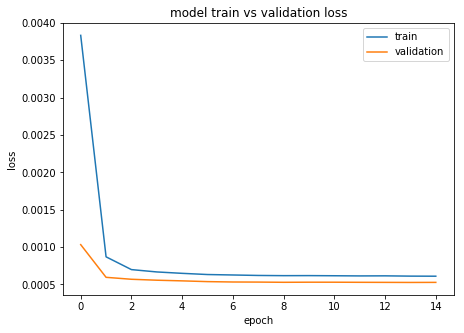

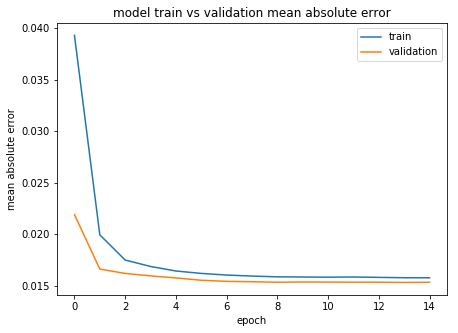

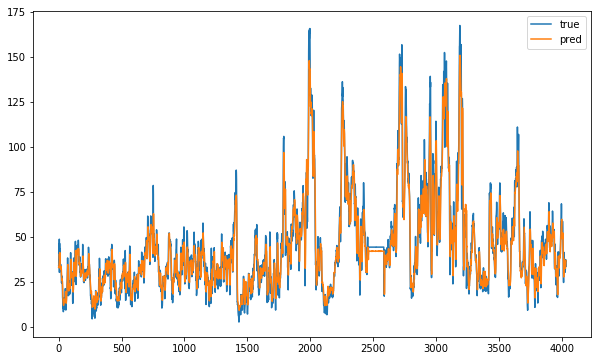

loss(test-set): 7.110267610921775

CNN_Filters:  30 LSTM_Size:  259
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 2, 30)       180       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1, 30)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 30)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 259)         300440    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 259)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 50)          13000     
_________________________________________________________________
dense_3 

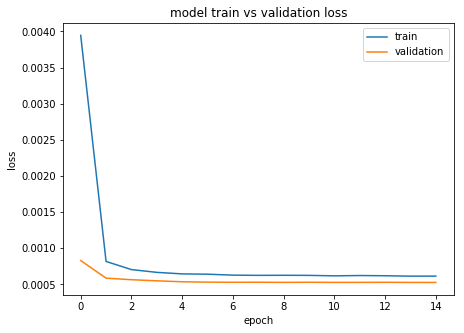

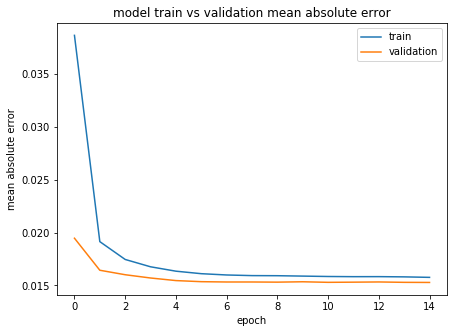

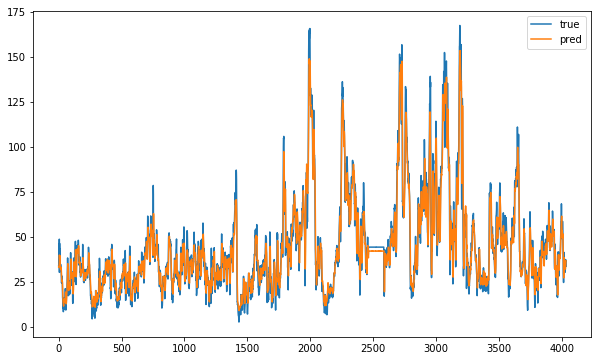

loss(test-set): 7.010964754806489

CNN_Filters:  30 LSTM_Size:  387
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 2, 30)       180       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 1, 30)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 30)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 387)         647064    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 387)         0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 50)          19400     
_________________________________________________________________
dense_5 

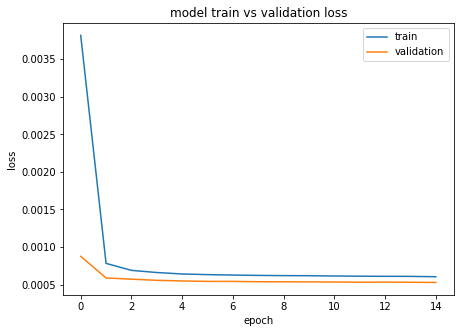

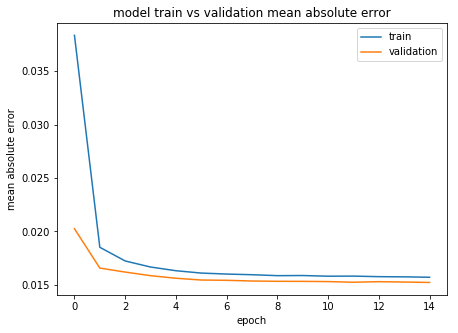

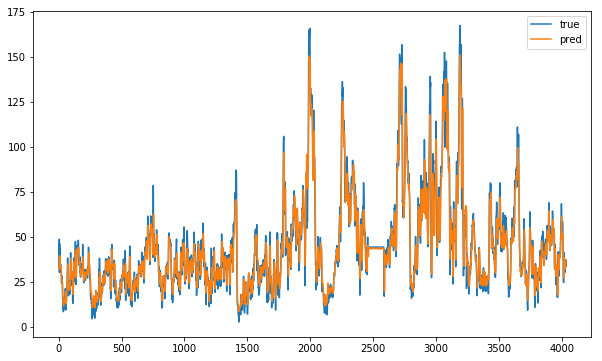

loss(test-set): 7.0295840539611785

CNN_Filters:  5 LSTM_Size:  800
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, None, 2, 5)        30        
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 1, 5)        0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 5)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 800)         2579200   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 800)         0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 50)          40050     
_________________________________________________________________
dense_7 

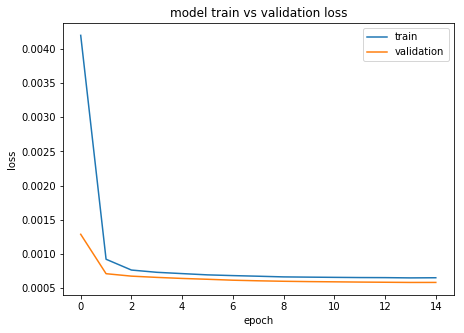

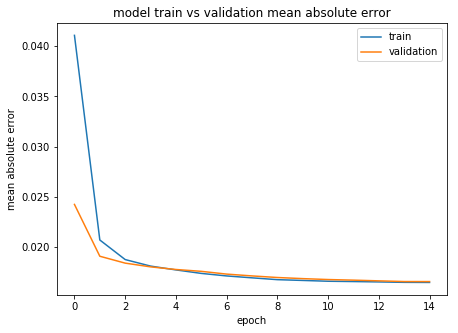

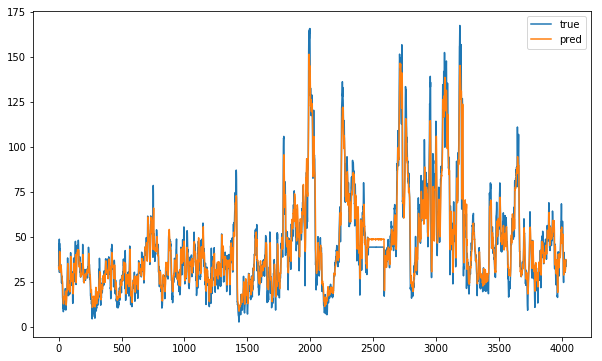

loss(test-set): 7.5969814901956765

CNN_Filters:  15 LSTM_Size:  479
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, None, 2, 15)       90        
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 479)         948420    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 479)         0         
_________________________________________________________________
dense_8 (Dense)              (None, None, 50)          24000     
_________________________________________________________________
dense_9

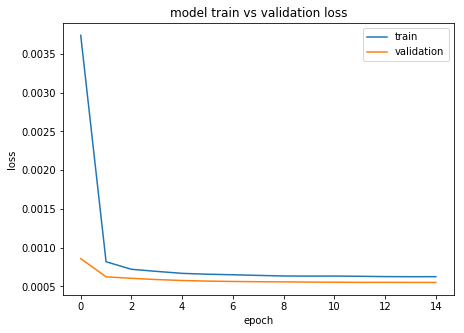

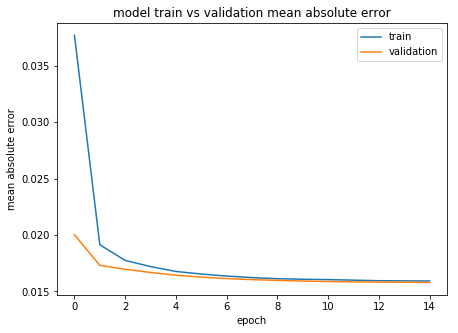

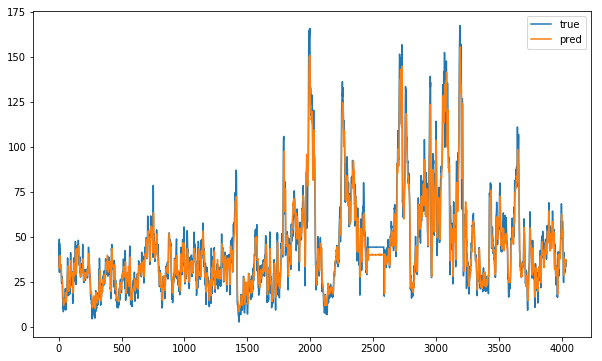

loss(test-set): 7.273383439891197

CNN_Filters:  9 LSTM_Size:  109
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 2, 9)        54        
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 1, 9)        0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 9)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 109)         51884     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 109)         0         
_________________________________________________________________
dense_10 (Dense)             (None, None, 50)          5500      
_________________________________________________________________
dense_11 

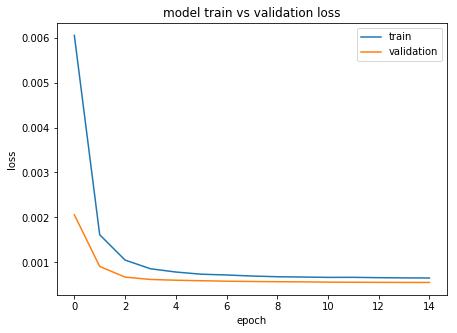

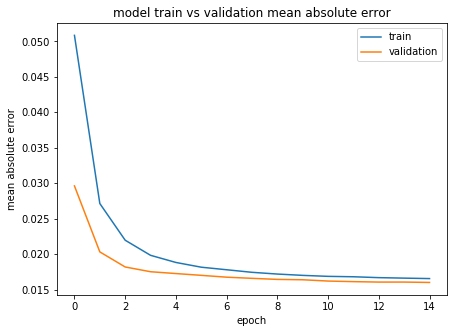

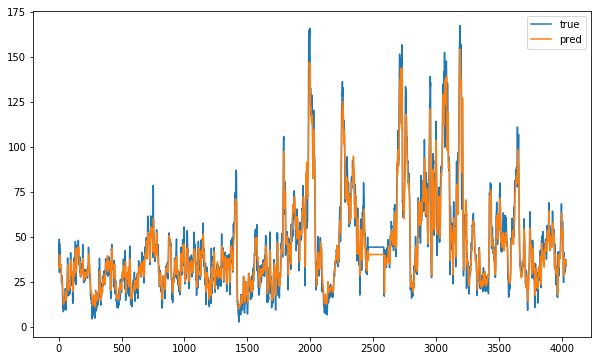

loss(test-set): 7.492508300611909

CNN_Filters:  24 LSTM_Size:  158
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, None, 2, 24)       144       
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 1, 24)       0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 24)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 158)         115656    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 158)         0         
_________________________________________________________________
dense_12 (Dense)             (None, None, 50)          7950      
_________________________________________________________________
dense_13

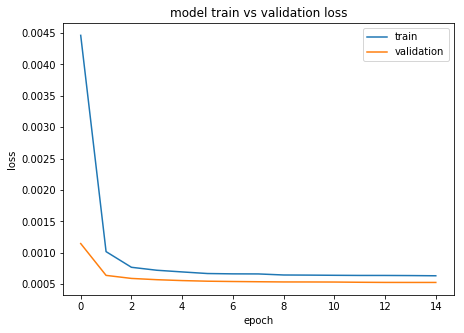

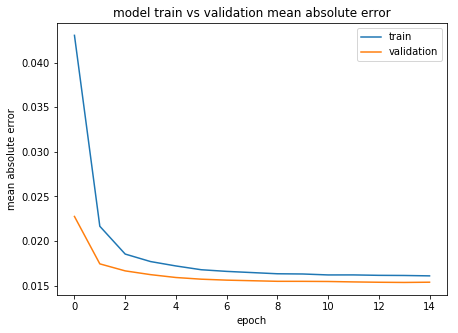

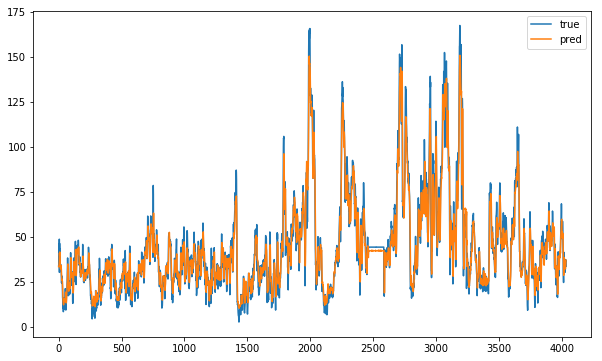

loss(test-set): 7.161081681017231

CNN_Filters:  2 LSTM_Size:  935
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, None, 2, 2)        12        
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 1, 2)        0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 2)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 935)         3508120   
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 935)         0         
_________________________________________________________________
dense_14 (Dense)             (None, None, 50)          46800     
_________________________________________________________________
dense_15 

In [ ]:
runGeneticAlgorithm()